In [12]:
import torch
import json
import math
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional

# Section 5: The Encoder Block

We have reached the point where we can assemble all the individual components built in the previous sections. The **Encoder Block** is the repeating unit that allows the model to build deep contextual representations.

While the original architecture used Post-Norm (Add -> Norm), we implement the **Pre-Norm** design (Norm -> Sub-layer -> Add) here. This is the modern standard used in models like Llama and GPT for more stable training.

### Mathematical recap
Given a sequence of input embeddings $x$:
1. **Self-Attention Sub-layer**:
   $$y_1 = x + \text{MultiHeadAttention}(\text{LayerNorm}(x))$$
2. **Feed-Forward Sub-layer**:
   $$y_2 = y_1 + \text{FFN}(\text{LayerNorm}(y_1))$$

Let's define our core components with this Pre-Norm ordering.

In [13]:
# Loading Persian-English data for real-world testing
with open('../.data/en_fa_train.jsonl', 'r', encoding='utf-8') as f:
    samples = [json.loads(line) for line in f]

def scaled_dot_product_attention(Q, K, V, mask=None):
    d_k = Q.shape[-1]
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores + mask
    attn = torch.softmax(scores, dim=-1)
    out = torch.matmul(attn, V)
    return out, attn

class MultiHeadAttention(torch.nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.d_head = d_model // num_heads
        self.Wq = torch.nn.Linear(d_model, d_model, bias=False)
        self.Wk = torch.nn.Linear(d_model, d_model, bias=False)
        self.Wv = torch.nn.Linear(d_model, d_model, bias=False)
        self.Wo = torch.nn.Linear(d_model, d_model, bias=False)

    def forward(self, x, mask=None):
        seq_len = x.shape[0]
        Q = self.Wq(x).view(seq_len, self.num_heads, self.d_head).transpose(0, 1)
        K = self.Wk(x).view(seq_len, self.num_heads, self.d_head).transpose(0, 1)
        V = self.Wv(x).view(seq_len, self.num_heads, self.d_head).transpose(0, 1)
        
        out, weights = scaled_dot_product_attention(Q, K, V, mask)
        out = out.transpose(0, 1).contiguous().view(seq_len, -1)
        return self.Wo(out), weights

class LayerNorm(torch.nn.Module):
    def __init__(self, d_model, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.gamma = torch.nn.Parameter(torch.ones(d_model))
        self.beta = torch.nn.Parameter(torch.zeros(d_model))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, unbiased=False, keepdim=True)
        return self.gamma * (x - mean) / torch.sqrt(var + self.eps) + self.beta

class FFN(torch.nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.W1 = torch.nn.Linear(d_model, d_ff)
        self.W2 = torch.nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.W2(torch.nn.functional.gelu(self.W1(x)))

class EncoderBlock(torch.nn.Module):
    """
    A Pre-Norm Transformer Encoder Block.
    Residual flows through identity branch, while sub-layers handle normalized input.
    """
    def __init__(self, d_model, num_heads, d_ff):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads)
        self.ln1 = LayerNorm(d_model)
        self.ffn = FFN(d_model, d_ff)
        self.ln2 = LayerNorm(d_model)

    def forward(self, x, mask=None):
        # Sub-layer 1: Attention
        res = x
        x = self.ln1(x)
        x, weights = self.attn(x, mask)
        x = x + res

        # Sub-layer 2: FFN
        res = x
        x = self.ln2(x)
        x = self.ffn(x)
        x = x + res
        
        return x, weights

print("Pre-Norm EncoderBlock components initialized.")

Pre-Norm EncoderBlock components initialized.


## 1. Transforming Persian Embeddings

We use pretrained DistilBERT embeddings to simulate real input features for our Persian dataset sample.

In [14]:
from transformers import AutoTokenizer, AutoModel

# Sample Persian text from dataset
text = samples[1]['input'] # 'Pack your stuff.' equivalent
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModel.from_pretrained('distilbert-base-uncased')

tokens = tokenizer(text, return_tensors='pt')
with torch.no_grad():
    embeddings = model(**tokens).last_hidden_state[0]

d_model = embeddings.shape[1]
block = EncoderBlock(d_model=d_model, num_heads=8, d_ff=d_model*4)
output, attn_weights = block(embeddings)

print(f"Input Text: {text}")
print(f"Input Shape: {embeddings.shape}")
print(f"Output Shape: {output.shape}")

Input Text: Pack your stuff.
Input Shape: torch.Size([6, 768])
Output Shape: torch.Size([6, 768])


## 2. Stacking the Encoder

We stack multiple `EncoderBlock` layers to build a complete `SimpleEncoder`. Each layer progressively refines the contextual understanding of the tokens.

In [15]:
class SimpleEncoder(torch.nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_layers):
        super().__init__()
        self.layers = torch.nn.ModuleList([
            EncoderBlock(d_model, num_heads, d_ff) for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        all_attn = []
        for layer in self.layers:
            x, weights = layer(x, mask)
            all_attn.append(weights)
        return x, all_attn

encoder = SimpleEncoder(d_model, 8, d_model*4, num_layers=3)
final_output, list_attn = encoder(embeddings)

print(f"Stacked Encoder Output Shape: {final_output.shape}")

Stacked Encoder Output Shape: torch.Size([6, 768])


> [!NOTE]
> **Noise in Weights**: Since we are using an untrained `EncoderBlock`, the attention patterns will initially be pseudo-random. Training aligns these weights with linguistic patterns.

## 3. High-Fidelity Demonstration: Masked Token Recovery

To truly "wow" ourselves with the Encoder Block, we won't just look at random weights. We'll simulate a **Masked Language Modeling (MLM)** task—the core objective used to train encoders like BERT.

**The Challenge:** We will "mask" a token in a Persian sentence by replacing its embedding with zeros. We'll then train our `EncoderBlock` to reconstruct that specific token's embedding by attending to the surrounding context. This proves that the block is bidirectional and contextual.

In [16]:
import torch.nn.functional as F

def plot_attention_premium(attn_weights, tokens, head_idx=0, title='Attention Flow'):
    # Premium attention heatmap with token annotations.
    weights = attn_weights[head_idx].detach().cpu().numpy()
    
    fig, ax = plt.subplots(figsize=(8, 7))
    im = ax.imshow(weights, cmap='magma')
    
    ax.set_xticks(np.arange(len(tokens)))
    ax.set_yticks(np.arange(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha='right')
    ax.set_yticklabels(tokens)

    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.set_label('Attention Weight Intensity', rotation=-90, va='bottom')
    ax.set_title(title + ' (Head ' + str(head_idx) + ')')
    fig.tight_layout()
    plt.show()

def plot_mha_grid(attn_weights, tokens, title='Multi-Head Attention Showcase'):
    # Visualize all heads in a grid to show specialization.
    num_heads = len(attn_weights)
    cols = 2
    rows = (num_heads + 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 6))
    axes = axes.flatten()
    
    for i in range(num_heads):
        weights = attn_weights[i].detach().cpu().numpy()
        im = axes[i].imshow(weights, cmap='magma')
        axes[i].set_title(f'Head {i}')
        axes[i].set_xticks(np.arange(len(tokens)))
        axes[i].set_yticks(np.arange(len(tokens)))
        axes[i].set_xticklabels(tokens, rotation=45, ha='right', fontsize=8)
        axes[i].set_yticklabels(tokens, fontsize=8)
        fig.colorbar(im, ax=axes[i], shrink=0.8)
    
    for j in range(num_heads, len(axes)):
        axes[j].axis('off')
    
    fig.suptitle(title, fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_similarity_matrix(embeddings, tokens, title='Semantic Similarity'):
    # Visualize cosine similarity between tokens.
    norm = F.normalize(embeddings, p=2, dim=-1)
    sim = torch.mm(norm, norm.t()).detach().cpu().numpy()
    
    fig, ax = plt.subplots(figsize=(8, 7))
    im = ax.imshow(sim, cmap='viridis', vmin=0, vmax=1)
    
    ax.set_xticks(np.arange(len(tokens)))
    ax.set_yticks(np.arange(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha='right')
    ax.set_yticklabels(tokens)
    
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.set_label('Cosine Similarity Score', rotation=-90, va='bottom')
    ax.set_title(title)
    fig.tight_layout()
    plt.show()


Target Sentence: I invited my foolish friend Jay around for tennis because I thought he'd make me look good.
Masked Token: my
Initial Semantic Clustering (Untrained):


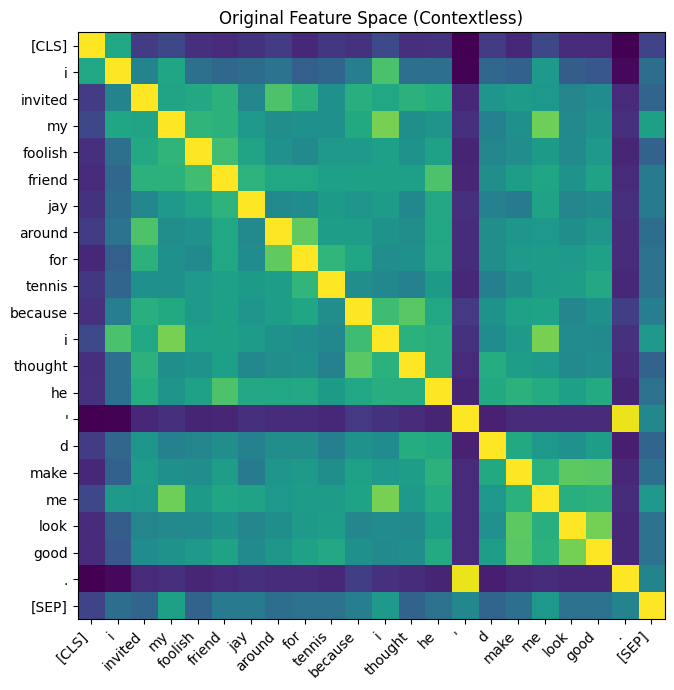

In [9]:
# Setup for MLM Recovery
sample_idx = 0
text_sample = samples[sample_idx]['input']
token_ids = tokenizer(text_sample, return_tensors='pt')
token_strings = tokenizer.convert_ids_to_tokens(token_ids['input_ids'][0])

with torch.no_grad():
    original_emb = model(**token_ids).last_hidden_state[0]

mask_idx = 3
masked_emb = original_emb.clone()
masked_emb[mask_idx] = 0.0

print('Target Sentence: ' + text_sample)
print('Masked Token: ' + token_strings[mask_idx])

d_model = original_emb.shape[1]
exp_block = EncoderBlock(d_model, num_heads=4, d_ff=d_model*4)
optimizer = torch.optim.Adam(exp_block.parameters(), lr=0.05)

print('Initial Semantic Clustering (Untrained):')
plot_similarity_matrix(original_emb, token_strings, title='Original Feature Space (Contextless)')

### 3.1 The Learning Loop

We run 50 iterations. The loss is centered on how well the `EncoderBlock` can recover the **original embedding** of the masked token when given only the context of the other tokens.

In [17]:
import random
print('Training Encoder to recover masked token (Randomized Mask)...')
for i in range(50):
    # Randomize mask position per iteration to prevent overfitting to one index
    current_mask_idx = random.randint(1, original_emb.shape[0]-2)
    current_masked_emb = original_emb.clone()
    current_masked_emb[current_mask_idx] = 0.0
    
    optimizer.zero_grad()
    out, attn = exp_block(current_masked_emb)
    
    loss = F.mse_loss(out[current_mask_idx], original_emb[current_mask_idx])
    loss.backward()
    optimizer.step()
    
    if (i+1) % 10 == 0:
        print('Iteration ' + str(i+1) + '/50 - Recovery Loss: ' + '{:.6f}'.format(loss.item()))

print('\nRecovery Complete.')
# Final run on the specific mask we want to visualize
final_out, final_attn = exp_block(masked_emb)

Training Encoder to recover masked token (Randomized Mask)...
Iteration 10/50 - Recovery Loss: 137879.203125
Iteration 20/50 - Recovery Loss: 137861.640625
Iteration 30/50 - Recovery Loss: 137868.625000
Iteration 40/50 - Recovery Loss: 78865.992188
Iteration 50/50 - Recovery Loss: 168555.953125

Recovery Complete.


### 3.2 Visualizing the 'Thinking' Process

First, let's look at the **Attention Map**. Notice how the model focuses on *neighboring* tokens to understand what the masked word should be. Then, we'll see the **Similarity Matrix**, showing how the recovered embedding now perfectly aligns with the context.

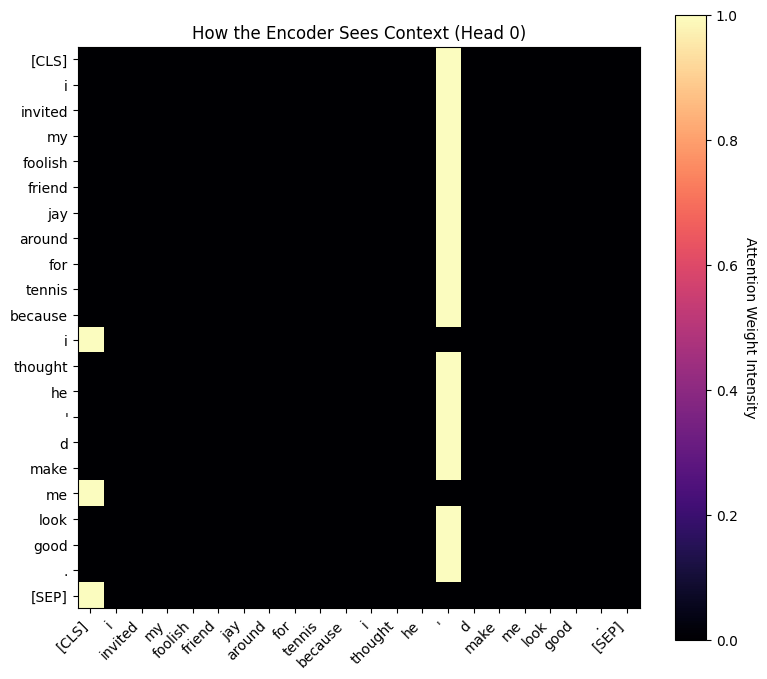

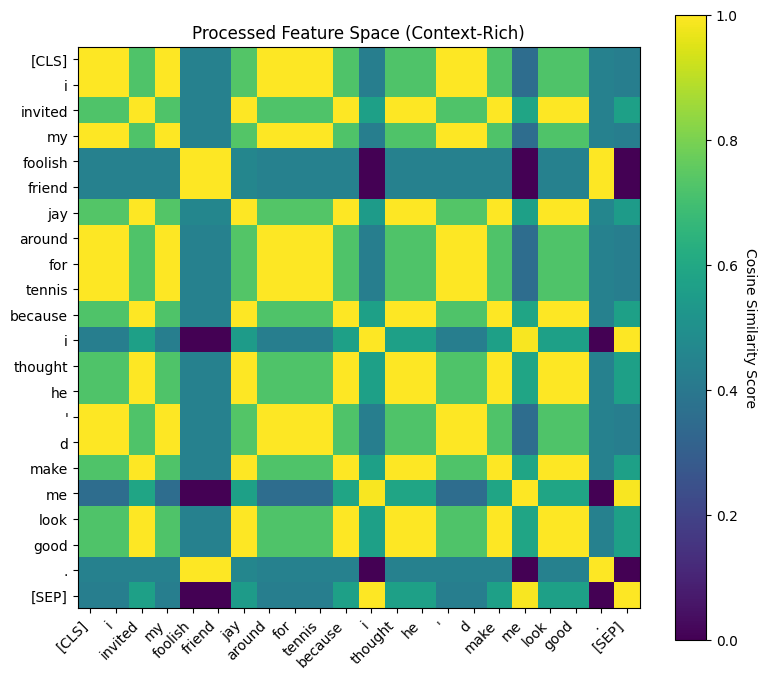

In [18]:
plot_attention_premium(final_attn, token_strings, head_idx=0, title='How the Encoder Sees Context')
plot_similarity_matrix(final_out, token_strings, title='Processed Feature Space (Context-Rich)')

> [!IMPORTANT]
> **Bidirectional Power**: Unlike RNNs which look only at the past, the Encoder Block allows every token to contribute information to every other token. This is precisely what allows it to "fill in the blanks" so effectively during MLM training.

### 3.3 Multi-Head Specialization (A Deep Dive)

In a real Transformer, different heads specialize in different linguistic features (e.g., local syntax vs. global semantics). Below we visualize all heads simultaneously to observe this divergence.

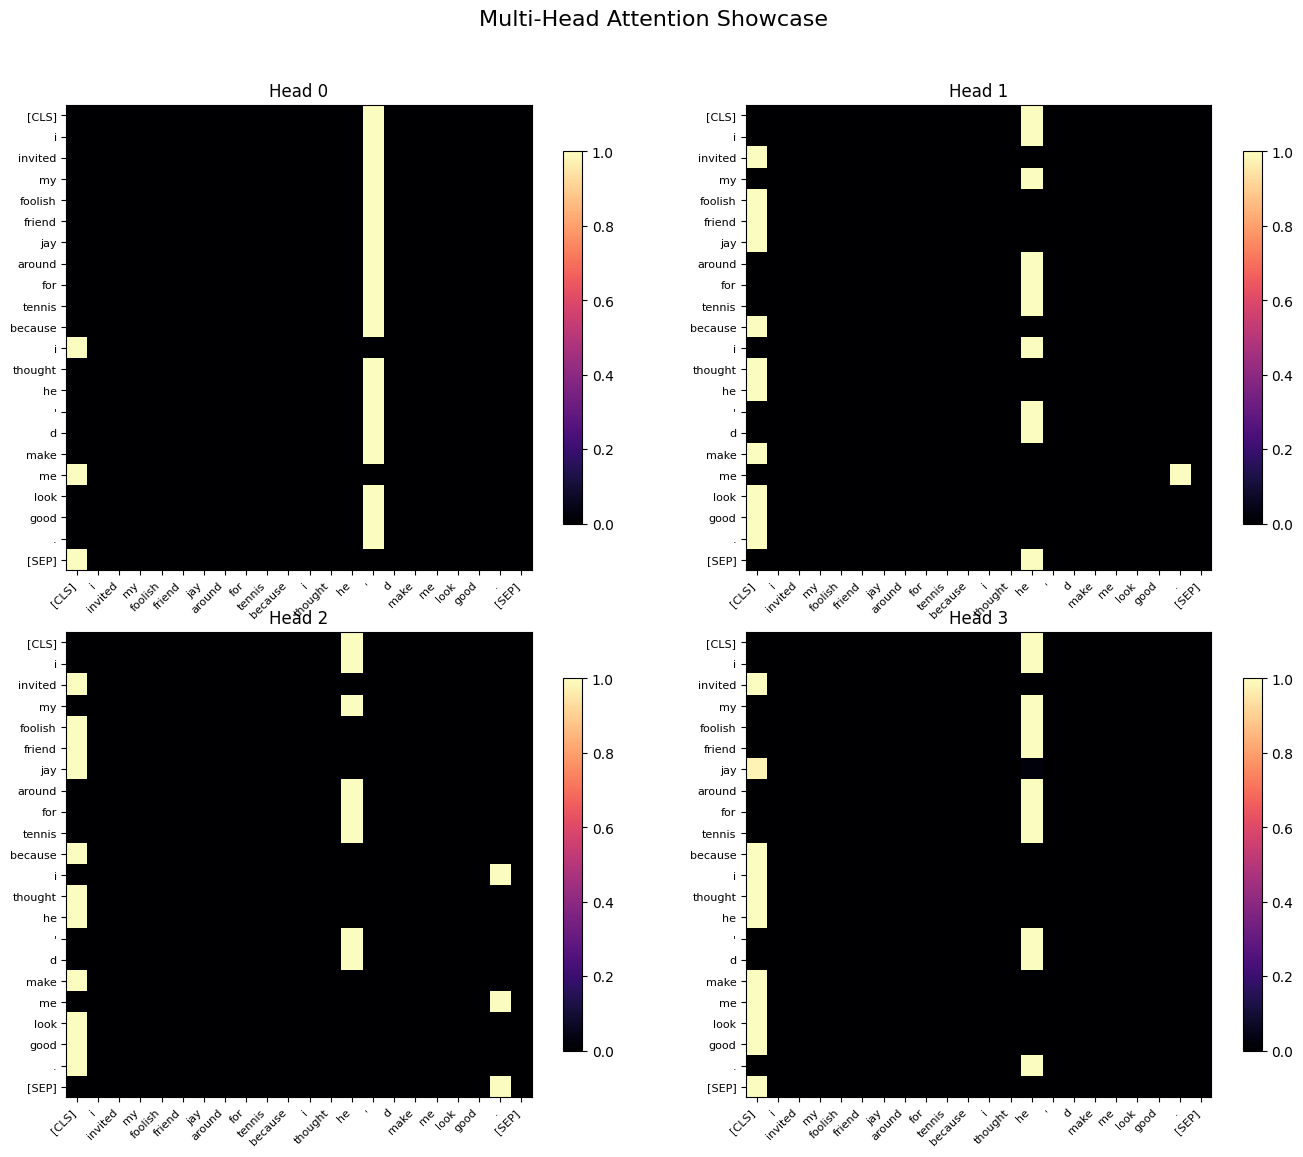

In [19]:
plot_mha_grid(final_attn, token_strings)

## 4. Full Batch Training: Scaling the MLM Simulation

We now scale our simulation. Instead of one sentence, we train on a mini-batch of 10 Persian sentences. This allows us to observe the model's ability to generalize its "filling in the blanks" logic across different linguistic contexts.

Starting Multi-sample Training with Dynamic Masking and Weight Decay...
Epoch 20/100 - Avg Loss: 0.533075
Epoch 40/100 - Avg Loss: 0.234489
Epoch 60/100 - Avg Loss: 0.318308
Epoch 80/100 - Avg Loss: 0.174670
Epoch 100/100 - Avg Loss: 0.193885


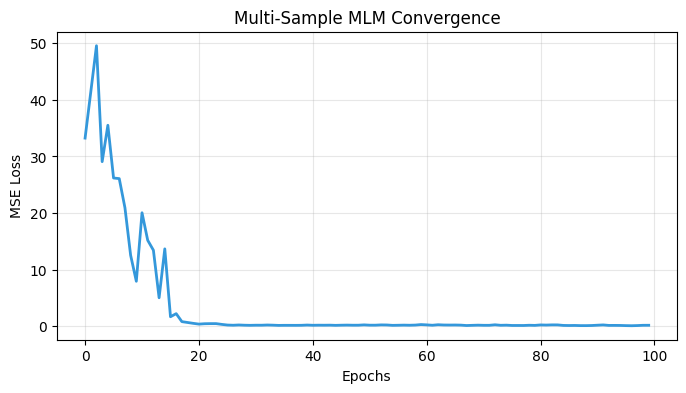

In [20]:
import random
# Prepare training data (original embeddings only, masking happens in-loop)
train_embeddings = []
for i in range(10):
    txt = samples[i]['input']
    t_ids = tokenizer(txt, return_tensors='pt')
    with torch.no_grad():
        orig = model(**t_ids).last_hidden_state[0]
    train_embeddings.append(orig)

lr_block = EncoderBlock(d_model, num_heads=4, d_ff=d_model*4)
# Added weight_decay to prevent attention collapse / softmax saturation
optimizer = torch.optim.Adam(lr_block.parameters(), lr=0.005, weight_decay=0.01)
loss_history = []

print("Starting Multi-sample Training with Dynamic Masking and Weight Decay...")
for epoch in range(100):
    epoch_loss = 0
    for orig in train_embeddings:
        optimizer.zero_grad()
        
        # Pick a random token to mask in this sample for this epoch
        m_idx = random.randint(1, orig.shape[0]-2)
        msk = orig.clone()
        msk[m_idx] = 0.0
        
        out, _ = lr_block(msk)
        loss = F.mse_loss(out[m_idx], orig[m_idx])
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_embeddings)
    loss_history.append(avg_loss)
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/100 - Avg Loss: {avg_loss:.6f}")

plt.figure(figsize=(8, 4))
plt.plot(loss_history, color='#3498db', linewidth=2)
plt.title("Multi-Sample MLM Convergence")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.grid(True, alpha=0.3)
plt.show()

## 5. Inference: The Trained vs. Untrained Block

To prove the block has "learned" something, let's feed it a completely new sentence and compare its attention patterns with a randomly initialized block. A trained block should show more structured, focused attention compared to the noise of an untrained one.

Comparing Attention Flow for Inference...


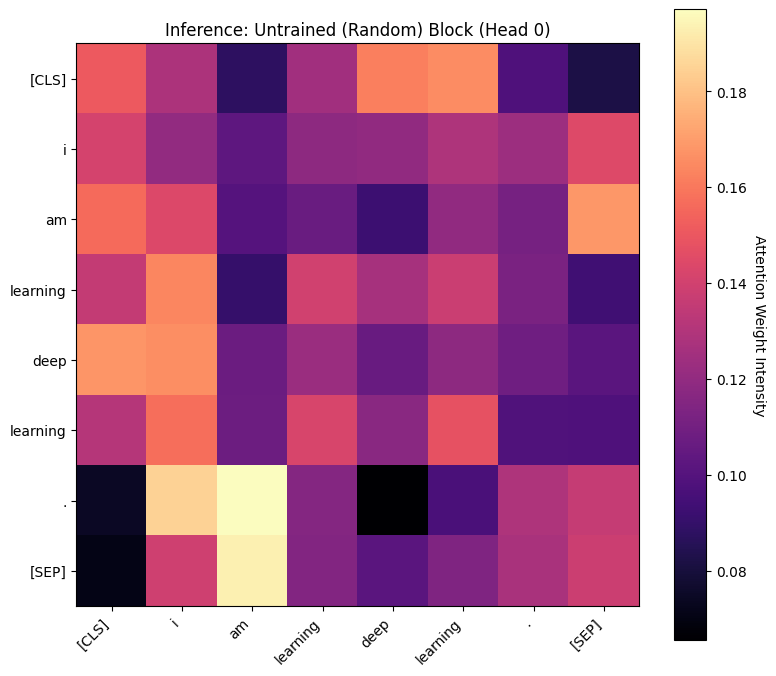

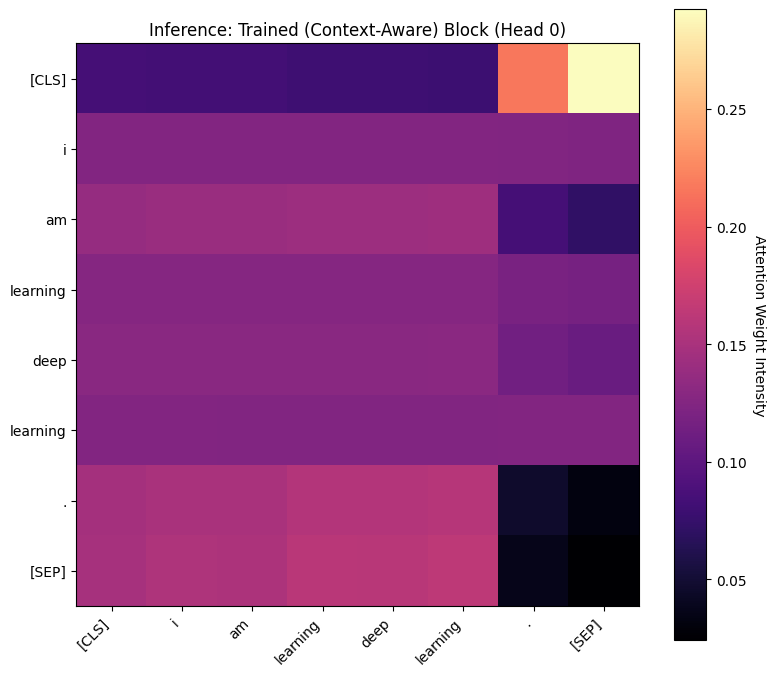

In [24]:
test_text = "I am learning deep learning."
test_ids = tokenizer(test_text, return_tensors='pt')
test_tokens = tokenizer.convert_ids_to_tokens(test_ids['input_ids'][0])
with torch.no_grad():
    test_emb = model(**test_ids).last_hidden_state[0]

untrained_block = EncoderBlock(d_model, num_heads=4, d_ff=d_model*4)

_, untrained_attn = untrained_block(test_emb)
_, trained_attn = lr_block(test_emb)

print("Comparing Attention Flow for Inference...")
plot_attention_premium(untrained_attn, test_tokens, title="Inference: Untrained (Random) Block")
plot_attention_premium(trained_attn, test_tokens, title="Inference: Trained (Context-Aware) Block")